In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from matplotlib.ticker import FormatStrFormatter

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, assemble_df, get_exact_p, get_fdr_p_df

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 200 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
# output file prefix
run_hemi = ''
if run_hemi == 'ipsi':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_ipsi_'
elif run_hemi == 'contra':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_contra_'
else:
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [8]:
phenos = ['Psychosis_Positive','Psychosis_NegativeDisorg','Overall_Psychopathology']
phenos_label = ['Psychosis (positive)','Psychosis (negative)','Overall psychopathology']
phenos_short = ['Psy. (pos)','Psy. (neg)','Ov. psy.']

print(phenos)

metrics = ['str', 'ac', 'bc', 'cc', 'sgc']
metrics_label = ['Strength', 'Average controllability', 'Betweenness centrality', 'Closeness centrality', 'Subgraph centrality']

algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']
seeds = np.arange(0,100)

['Psychosis_Positive', 'Psychosis_NegativeDisorg', 'Overall_Psychopathology']


In [9]:
num_algs = len(algs)
num_metrics = len(metrics)
num_phenos = len(phenos)
num_scores = len(scores)

## Setup plots

In [10]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})
cmap = my_get_cmap('pair')

## Load data

In [11]:
df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

num_subjects = df_pheno.shape[0]

In [12]:
score = scores[1]; print(score)

rmse


In [13]:
predictiondir = os.path.join(os.environ['PIPELINEDIR'], '3_prediction_rnr', 'out', outfile_prefix)
predictiondir

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_'

### Load random splits cross-val (with nuis)

In [14]:
extra_str = ''
# extra_str = '_agesplit'
extra_str1 = ''
# extra_str1 = '_agelow'
# extra_str1 = '_agehigh'

In [15]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'+extra_str
print(indir)

accuracy_mean_nuis = np.zeros((100, len(algs), len(metrics), len(phenos)))
accuracy_std_nuis = np.zeros((100, len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
#         if metric == 'ac':
#             indir = predictiondir + 'predict_symptoms_rcv_nuis_ac_i2'
#         else:
#             indir = predictiondir + 'predict_symptoms_rcv_nuis'
            
        for p, pheno in enumerate(phenos):
            accuracy_mean_nuis[:,a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean'+extra_str1+'.txt'))
            accuracy_std_nuis[:,a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_std'+extra_str1+'.txt'))

if score == 'rmse' or score == 'mae':
    accuracy_mean_nuis = np.abs(accuracy_mean_nuis)
    accuracy_std_nuis = np.abs(accuracy_std_nuis)
                
print(accuracy_mean_nuis.shape)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_predict_symptoms_rcv_nuis
(100, 2, 5, 3)


### Load stratified cross-val (with nuis)

In [16]:
indir = predictiondir + 'predict_symptoms_scv_nuis'+extra_str
print(indir)

scv_accuracy_mean_nuis = np.zeros((len(algs), len(metrics), len(phenos)))
scv_accuracy_std_nuis = np.zeros((len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            scv_accuracy_mean_nuis[a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_nuis'+extra_str1+'.txt'))
            scv_accuracy_std_nuis[a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_std_nuis'+extra_str1+'.txt'))

if score == 'rmse' or score == 'mae':
    scv_accuracy_mean_nuis = np.abs(scv_accuracy_mean_nuis)
    scv_accuracy_std_nuis = np.abs(scv_accuracy_std_nuis)
                
print(scv_accuracy_mean_nuis.shape)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_predict_symptoms_scv_nuis
(2, 5, 3)


# Plot results

### Figure S5

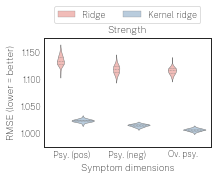

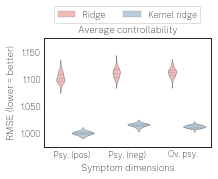

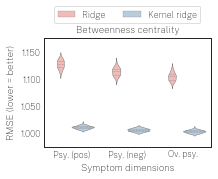

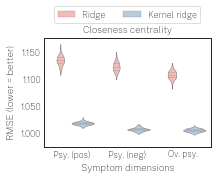

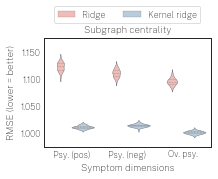

In [17]:
if score == 'rmse':
    for m, metric in enumerate(metrics):
        f, ax = plt.subplots()
        f.set_figwidth(3)
        f.set_figheight(2)

        df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
        df = df.loc[df.loc[:,'metric'] == metric,:]
        df.loc[df.loc[:,'alg'] == 'rr','alg'] = 'Ridge'
        df.loc[df.loc[:,'alg'] == 'krr_rbf','alg'] = 'Kernel ridge'

        sns.violinplot(x = 'pheno', y = 'score', hue = 'alg', data = df, ax = ax, inner = 'quartile', split = False, linewidth = 0.5, palette = 'Pastel1')
        ax.tick_params(pad = -2)
        ax.set_title(metrics_label[m])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
        ax.set_xticklabels(phenos_short)
        ax.set_xlabel('Symptom dimensions')
        if score == 'rmse': ax.set_ylabel('RMSE (lower = better)')
        elif score == 'corr': ax.set_ylabel('corr(y_true,y_pred)')

        if score == 'rmse' and parc_scale == 200: ax.set_ylim([0.975,1.175])
        elif score == 'rmse' and parc_scale == 400: ax.set_ylim([0.95,1.45])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        f.savefig(outfile_prefix+'model_selection_'+metric+'.svg', dpi = 300, bbox_inches = 'tight')

In [18]:
a = 1; alg = algs[a]; print(alg)

krr_rbf


### Figure 2

In [19]:
metric_pairs = ['str_ac', 'str_bc', 'str_cc', 'str_sgc',
                'ac_bc', 'ac_cc', 'ac_sgc',
                'bc_cc', 'bc_sgc',
                'cc_sgc']

stats_metric_pairs = pd.DataFrame(index = phenos)
for pheno in phenos:
    for metric in metric_pairs:
        metric_x = metric.split('_')[0]
        metric_y = metric.split('_')[1]
        
        df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
        df = df.loc[df.loc[:,'alg'] == alg,:]
        df = df.loc[df.loc[:,'pheno'] == pheno,:]

        x = df.loc[df.loc[:,'metric'] == metric_x,'score']
        y = df.loc[df.loc[:,'metric'] == metric_y,'score']
        stats_metric_pairs.loc[pheno,metric_x+'_'+metric_y] = get_exact_p(x, y)
    
stats_metric_pairs = get_fdr_p_df(stats_metric_pairs)

stats_metric_pairs[stats_metric_pairs<.05]

,str_ac,str_bc,str_cc,str_sgc,ac_bc,ac_cc,ac_sgc,bc_cc,bc_sgc,cc_sgc
Psychosis_Positive,0.0,0.0,NaN,0.042857,0.000000,0.0,0.0,0.0,NaN,0.042857
Psychosis_NegativeDisorg,NaN,0.0,NaN,NaN,0.042857,NaN,NaN,NaN,0.0,0.000000
Overall_Psychopathology,NaN,NaN,NaN,NaN,0.000000,NaN,0.0,NaN,NaN,NaN


#### Permutation

In [20]:
indir = predictiondir + 'predict_symptoms_scv_nuis'+extra_str

stats_permutation = pd.DataFrame(index = phenos, columns = metrics)

for p, pheno in enumerate(phenos):
    for m, metric in enumerate(metrics):
        accuracy_mean = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_nuis'+extra_str1+'.txt'))
        permuted_acc = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'permuted_acc_nuis'+extra_str1+'.txt'))
        
        stats_permutation.loc[pheno,metric] = np.sum(permuted_acc >= accuracy_mean) / len(permuted_acc)

# multiple comparisons
if parc_str == 'schaefer' and parc_scale == 200:
    stats_permutation = get_fdr_p_df(stats_permutation, rows = False)

stats_permutation[stats_permutation < 0.05]

,str,ac,bc,cc,sgc
Psychosis_Positive,NaN,0.04485,NaN,NaN,NaN
Psychosis_NegativeDisorg,NaN,NaN,NaN,NaN,NaN
Overall_Psychopathology,NaN,NaN,NaN,NaN,NaN


In [21]:
m=1; print(metrics[m])
p=0; print(phenos[p])

print(np.round(scv_accuracy_mean_nuis[a,m,p],2))
print(np.round(stats_permutation.loc[phenos[p],metrics[m]],2))

ac
Psychosis_Positive
1.0
0.04


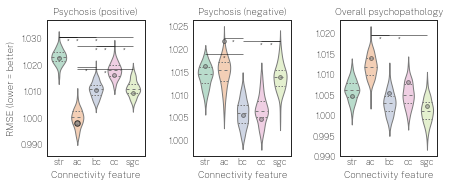

In [22]:
f, ax = plt.subplots(1, len(phenos))
f.set_figwidth(7)
f.set_figheight(2.5)

for i, pheno in enumerate(phenos): 
    pheno_label = phenos_label[i]

    df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
    df = df.loc[df.loc[:,'alg'] == alg,:]
    df = df.loc[df.loc[:,'pheno'] == pheno,:]

    sns.violinplot(x = 'metric', y = 'score', data = df, ax = ax[i], inner = 'quartile', split = False, palette = 'Pastel2', linewidth = 1)
    ax[i].tick_params(pad = -.5)

    if score == 'rmse':
        ax[i].set_title(pheno_label)

    if i == 0:
        if score == 'rmse':
            ax[i].set_ylabel('RMSE (lower = better)')
            ax[i].set_ylim([ax[i].get_ylim()[0]-ax[i].get_ylim()[0]*.002,
                            ax[i].get_ylim()[1]+ax[i].get_ylim()[1]*.002])
        elif score == 'corr':
            ax[i].set_ylabel('Correlation (higher = better)')
    else:
            ax[i].set_ylabel('')

    ax[i].set_xlabel('Connectivity feature')
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    for tick in ax[i].xaxis.get_majorticklabels():
        tick.set_y(.025)

    for metric_pair in metric_pairs:
        metric_x = metric_pair.split('_')[0]
        metric_x_loc = metrics.index(metric_x)
        metric_y = metric_pair.split('_')[1]
        metric_y_loc = metrics.index(metric_y)
        
        if stats_metric_pairs.loc[pheno,metric_pair] < 0.05:
            y_pos = df.loc[np.logical_or(df.loc[:,'metric'] == metric_x,df.loc[:,'metric'] == metric_y),'score'].max()
            ax[i].hlines(y = y_pos, xmin = ax[i].get_xticks()[metric_x_loc], xmax = ax[i].get_xticks()[metric_y_loc], color = 'black', linewidth = 0.5)
            ax[i].text(x = np.mean([ax[i].get_xticks()[metric_y_loc],ax[i].get_xticks()[metric_x_loc]]), y = y_pos, s =  '*', horizontalalignment='center', verticalalignment='top', color = 'black', fontsize = 8)

    # add stratified cv score
    for m, metric in enumerate(metrics):
        if stats_permutation.loc[pheno,metric] < 0.05:
            ax[i].scatter(x = m, y = scv_accuracy_mean_nuis[a,m,i], marker = 'o', s = 30, edgecolors = 'black', facecolors = 'gray', alpha = 0.75, linewidth = 1)
        else:
            ax[i].scatter(x = m, y = scv_accuracy_mean_nuis[a,m,i], marker = 'o', s = 30/2, edgecolors = 'black', facecolors = 'gray', alpha = 0.5, linewidth = .75)

plt.subplots_adjust(wspace=0.5)
        
f.savefig(outfile_prefix+'performance_comparison_'+alg+'_'+score+'.svg', dpi = 300, bbox_inches = 'tight')

### Correlate across scores

In [23]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
print(indir)
accuracy_mean_nuis_rmse = np.zeros((100, len(metrics), len(phenos)))

for m, metric in enumerate(metrics):
    for p, pheno in enumerate(phenos):
        accuracy_mean_nuis_rmse[:,m,p] = np.loadtxt(os.path.join(indir, alg + '_rmse_' + metric + '_' + pheno, 'accuracy_mean.txt'))

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_predict_symptoms_rcv_nuis


In [24]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
print(indir)
accuracy_mean_nuis_corr = np.zeros((100, len(metrics), len(phenos)))

for m, metric in enumerate(metrics):
    for p, pheno in enumerate(phenos):
        accuracy_mean_nuis_corr[:,m,p] = np.loadtxt(os.path.join(indir, alg + '_corr_' + metric + '_' + pheno, 'accuracy_mean.txt'))

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_predict_symptoms_rcv_nuis


In [25]:
rmse_corr_corr = np.zeros((len(metrics), len(phenos)))

for m, metric in enumerate(metrics):
    for p, pheno in enumerate(phenos):
        rmse_corr_corr[m,p] = sp.stats.pearsonr(accuracy_mean_nuis_rmse[:,m,p], accuracy_mean_nuis_corr[:,m,p])[0]

In [26]:
rmse_corr_corr.mean()

0.8880636981329632

In [27]:
rmse_corr_corr.std()

0.015734300127713693

<AxesSubplot:>

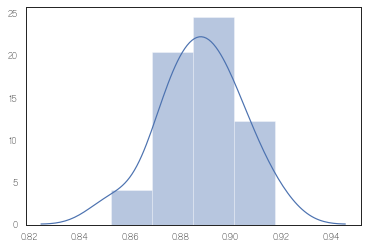

In [28]:
sns.distplot(rmse_corr_corr)

### Load random splits nested cross-val (without nuis)

In [29]:
nested_score_mean = np.load(os.path.join(predictiondir+'predict_symptoms_ncv', 'nested_score_mean.npy'))
print(nested_score_mean.shape)

if score == 'corr':
    nested_score_mean = nested_score_mean[:,:,0,:,:]
elif score == 'rmse':
    nested_score_mean = nested_score_mean[:,:,1,:,:]
    nested_score_mean = np.abs(nested_score_mean)

print(nested_score_mean.shape)

(100, 2, 2, 5, 3)
(100, 2, 5, 3)


### Figure S6

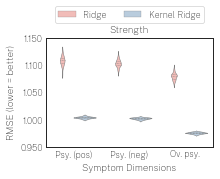

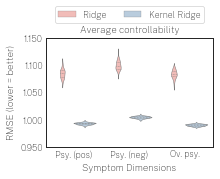

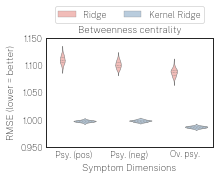

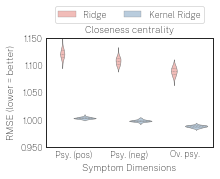

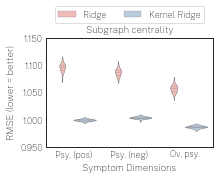

In [30]:
if score == 'rmse':
    for m, metric in enumerate(metrics):
        f, ax = plt.subplots()
        f.set_figwidth(3)
        f.set_figheight(2)

        df = assemble_df(nested_score_mean, algs, metrics, phenos)
        df = df.loc[df.loc[:,'metric'] == metric,:]
        df.loc[df.loc[:,'alg'] == 'rr','alg'] = 'Ridge'
        df.loc[df.loc[:,'alg'] == 'krr_rbf','alg'] = 'Kernel Ridge'

        sns.violinplot(x = 'pheno', y = 'score', hue = 'alg', data = df, ax = ax, inner = 'quartile', split = False, linewidth = 0.5, palette = 'Pastel1')
    #     if score == 'rmse': ax.axhline(y = 1, color = 'black', linestyle = ':')
        ax.tick_params(pad = -2)
        ax.set_title(metrics_label[m])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
        ax.set_xticklabels(phenos_short)
        ax.set_xlabel('Symptom Dimensions')
        if score == 'rmse': ax.set_ylabel('RMSE (lower = better)')
        elif score == 'corr': ax.set_ylabel('corr(y_true,y_pred)')

        if score == 'rmse' and parc_scale == 200: ax.set_ylim([0.95,1.15])
        elif score == 'rmse' and parc_scale == 400: ax.set_ylim([0.95,1.4])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        f.savefig(outfile_prefix+'model_selection_2_'+metric+'.svg', dpi = 300, bbox_inches = 'tight')

### Figure S8

In [31]:
stats_metric_pairs = pd.DataFrame(index = phenos)
for pheno in phenos:
    for metric in metric_pairs:
        metric_x = metric.split('_')[0]
        metric_y = metric.split('_')[1]
        
        df = assemble_df(nested_score_mean, algs, metrics, phenos)
        df = df.loc[df.loc[:,'alg'] == alg,:]
        df = df.loc[df.loc[:,'pheno'] == pheno,:]

        x = df.loc[df.loc[:,'metric'] == metric_x,'score']
        y = df.loc[df.loc[:,'metric'] == metric_y,'score']
        stats_metric_pairs.loc[pheno,metric_x+'_'+metric_y] = get_exact_p(x, y)
    
stats_metric_pairs = get_fdr_p_df(stats_metric_pairs)

stats_metric_pairs[stats_metric_pairs<.05]

,str_ac,str_bc,str_cc,str_sgc,ac_bc,ac_cc,ac_sgc,bc_cc,bc_sgc,cc_sgc
Psychosis_Positive,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.04
Psychosis_NegativeDisorg,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.00
Overall_Psychopathology,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


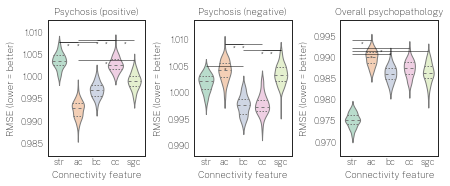

In [32]:
f, ax = plt.subplots(1, len(phenos))
f.set_figwidth(7)
f.set_figheight(2.5)

for i, pheno in enumerate(phenos): 
    pheno_label = phenos_label[i]

    df = assemble_df(nested_score_mean, algs, metrics, phenos)
    df = df.loc[df.loc[:,'alg'] == alg,:]
    df = df.loc[df.loc[:,'pheno'] == pheno,:]

    sns.violinplot(x = 'metric', y = 'score', data = df, ax = ax[i], inner = 'quartile', split = False, palette = 'Pastel2', linewidth = 1)
    ax[i].tick_params(pad = -.5)

    ax[i].set_title(pheno_label)
    if score == 'rmse':
        ax[i].set_ylabel('RMSE (lower = better)')
        ax[i].set_ylim([ax[i].get_ylim()[0]-ax[i].get_ylim()[0]*.002,
                        ax[i].get_ylim()[1]+ax[i].get_ylim()[1]*.002])
    elif score == 'corr':
        ax[i].set_ylabel('Correlation (higher = better)')

    ax[i].set_xlabel('Connectivity feature')
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    for tick in ax[i].xaxis.get_majorticklabels():
        tick.set_y(.025)
        
    for metric_pair in metric_pairs:
        metric_x = metric_pair.split('_')[0]
        metric_x_loc = metrics.index(metric_x)
        metric_y = metric_pair.split('_')[1]
        metric_y_loc = metrics.index(metric_y)
        
        if stats_metric_pairs.loc[pheno,metric_pair] < 0.05:
            y_pos = df.loc[np.logical_or(df.loc[:,'metric'] == metric_x,df.loc[:,'metric'] == metric_y),'score'].max()
            ax[i].hlines(y = y_pos, xmin = ax[i].get_xticks()[metric_x_loc], xmax = ax[i].get_xticks()[metric_y_loc], color = 'black', linewidth = 0.5)
            ax[i].text(x = np.mean([ax[i].get_xticks()[metric_y_loc],ax[i].get_xticks()[metric_x_loc]]), y = y_pos, s =  '*', horizontalalignment='center', verticalalignment='top', color = 'black', fontsize = 8)

plt.subplots_adjust(wspace=0.5)
        
f.savefig(outfile_prefix+'performance_comparison_2_'+alg+'.svg', dpi = 300, bbox_inches = 'tight')